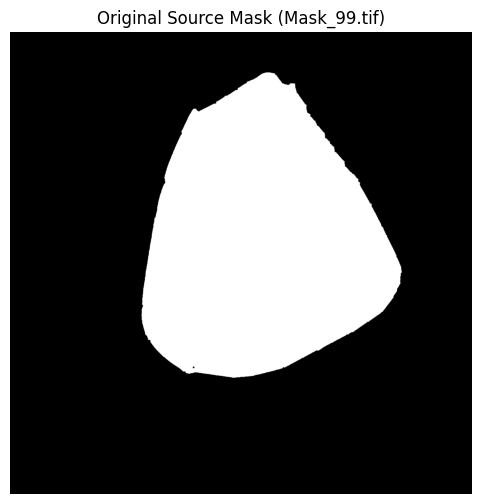

Source ellipse parameters:
  Centroid (row, col): (1108.08, 1334.21)
  Orientation (horizontal-based): 1.66 rad
  Major axis: 1568.02, Minor axis: 1308.49

Destination ellipse parameters:
  Centroid (row, col): (1671.53, 1460.26)
  Adjusted Centroid (large canvas): (2465.03, 2253.76)
  Orientation (horizontal-based): 1.48 rad
  Major axis: 1719.71, Minor axis: 1435.04

Extra pure shift required: Δx = -967.86, Δy = 397.39


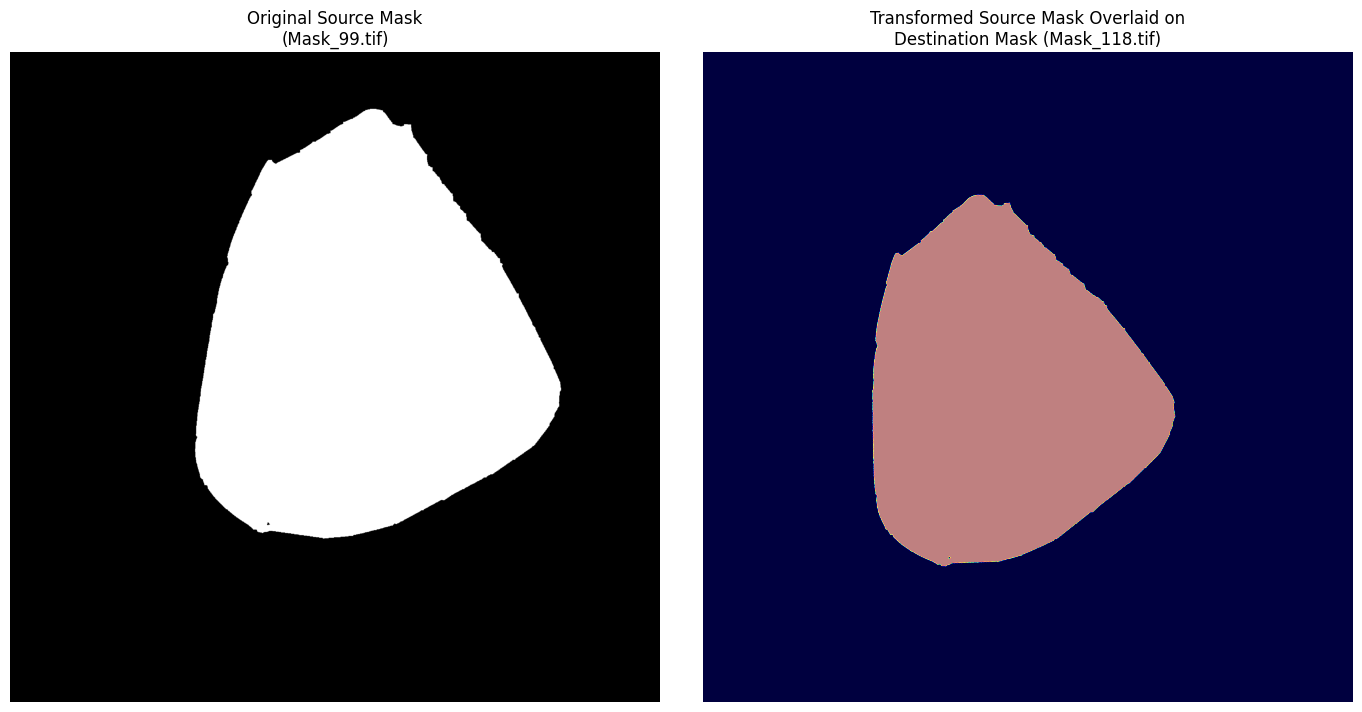

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float

##############################################
# Functions for Ellipse-Based Affine Transform
##############################################
def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the ellipse defined by
    (cx_s, cy_s, orient_s, major_s, minor_s) to the ellipse
    (cx_t, cy_t, orient_t, major_t, minor_t).

    Steps:
      1) Translate source centroid to origin.
      2) Rotate by -orient_s (align major axis with x-axis).
      3) Scale x by (major_t/major_s) and y by (minor_t/minor_s).
      4) Rotate by orient_t.
      5) Translate to target centroid.
    """
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    R1 = transform.AffineTransform(rotation=-orient_s)
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    R2 = transform.AffineTransform(rotation=orient_t)
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))
    return T2 + R2 + S + R1 + T1

def draw_axes(ax, centroid, orientation, major_len, minor_len, color='red', label_prefix=''):
    """
    Draws the centroid, major axis, and minor axis on the given axes 'ax'.
    'orientation' is measured from the HORIZONTAL axis.
    """
    cy, cx = centroid  # regionprops returns (row, col)
    ax.plot(cx, cy, marker='o', color=color, markersize=8, label=f'{label_prefix} Centroid')
    ax.text(cx + 5, cy + 5, f'({cy:.1f}, {cx:.1f})', color=color, fontsize=10)
    
    half_major = major_len / 2.0
    dx_major = half_major * np.cos(orientation)
    dy_major = half_major * np.sin(orientation)
    ax.arrow(cx, cy, dx_major, dy_major,
             head_width=5, head_length=5, fc=color, ec=color,
             label=f'{label_prefix} Major Axis')
    
    half_minor = minor_len / 2.0
    orientation_minor = orientation + np.pi / 2
    dx_minor = half_minor * np.cos(orientation_minor)
    dy_minor = half_minor * np.sin(orientation_minor)
    ax.arrow(cx, cy, dx_minor, dy_minor,
             head_width=5, head_length=5, fc=color, ec=color, linestyle='--',
             label=f'{label_prefix} Minor Axis')

##############################################
# 1. Load and binarize the masks
##############################################
# Read the source (to be transformed) and destination masks.
src = img_as_float(io.imread('Mask_99.tif', as_gray=True))
dst = img_as_float(io.imread('Mask_118.tif', as_gray=True))
mask_src = src > 0.5
mask_dst = dst > 0.5

# For visualization, show the original source mask.
plt.figure(figsize=(6,6))
plt.imshow(mask_src, cmap='gray')
plt.title("Original Source Mask (Mask_99.tif)")
plt.axis('off')
plt.show()

##############################################
# 2. Prepare a Larger Canvas for the Destination
##############################################
# Get target dimensions and create a larger canvas (1.5x)
H, W = mask_dst.shape
newH, newW = int(1.5 * H), int(1.5 * W)
offset_y, offset_x = (newH - H) / 2.0, (newW - W) / 2.0

##############################################
# 3. Compute Ellipse Parameters Using Regionprops
##############################################
props_src = measure.regionprops(mask_src.astype(int))
props_dst = measure.regionprops(mask_dst.astype(int))

# Assume the largest connected region in each mask:
region_src = props_src[0]
region_dst = props_dst[0]

# Centroids (row, col)
cy_s, cx_s = region_src.centroid
cy_t, cx_t = region_dst.centroid
# Adjust target centroid for the larger canvas:
cy_t_large = cy_t + offset_y
cx_t_large = cx_t + offset_x

# regionprops.orientation is measured from the vertical axis.
# Convert to an angle from the horizontal axis:
orient_s = np.pi/2 - region_src.orientation
orient_t = np.pi/2 - region_dst.orientation

# Major and minor axis lengths
major_s = region_src.major_axis_length
minor_s = region_src.minor_axis_length
major_t = region_dst.major_axis_length
minor_t = region_dst.minor_axis_length

print("Source ellipse parameters:")
print(f"  Centroid (row, col): ({cy_s:.2f}, {cx_s:.2f})")
print(f"  Orientation (horizontal-based): {orient_s:.2f} rad")
print(f"  Major axis: {major_s:.2f}, Minor axis: {minor_s:.2f}")

print("\nDestination ellipse parameters:")
print(f"  Centroid (row, col): ({cy_t:.2f}, {cx_t:.2f})")
print(f"  Adjusted Centroid (large canvas): ({cy_t_large:.2f}, {cx_t_large:.2f})")
print(f"  Orientation (horizontal-based): {orient_t:.2f} rad")
print(f"  Major axis: {major_t:.2f}, Minor axis: {minor_t:.2f}")

##############################################
# 4. Compute the Affine Transformation
##############################################
affine_tform = ellipse_to_ellipse_transform(
    cx_s, cy_s, orient_s, major_s, minor_s,
    cx_t_large, cy_t_large, orient_t, major_t, minor_t
)

##############################################
# 5. Warp the Source Mask on the Large Canvas
##############################################
warped_src = transform.warp(mask_src.astype(float),
                            inverse_map=affine_tform.inverse,
                            output_shape=(newH, newW))
# Re-binarize the warped image
warped_src_bin = warped_src > 0.5

# Compute region properties of the warped source to assess extra shift
props_warped = measure.regionprops(warped_src_bin.astype(int))
region_warped = props_warped[0]
cy_w, cx_w = region_warped.centroid

# Compute extra translation needed to align the centroids.
delta_x = cx_t_large - cx_w
delta_y = cy_t_large - cy_w
print(f"\nExtra pure shift required: Δx = {delta_x:.2f}, Δy = {delta_y:.2f}")

# Create a pure translation transform and apply it.
T_adjust = transform.AffineTransform(translation=(delta_x, delta_y))
warped_src_adjusted = transform.warp(warped_src_bin.astype(float),
                                     inverse_map=T_adjust.inverse,
                                     output_shape=(newH, newW))
warped_src_adjusted_bin = warped_src_adjusted > 0.5

##############################################
# 6. Crop the Final Warped Image to the Target Size
##############################################
offset_y_int = int(offset_y)
offset_x_int = int(offset_x)
final_warped = warped_src_adjusted_bin[offset_y_int:offset_y_int+H, offset_x_int:offset_x_int+W]

##############################################
# 7. Visualization: Pre and Post Transformation
##############################################
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Left: Original Source Mask
axes[0].imshow(mask_src, cmap='gray')
axes[0].set_title("Original Source Mask\n(Mask_99.tif)")
axes[0].axis('off')

# Right: Transformed Source Mask overlaid on Destination Mask
axes[1].imshow(mask_dst, cmap='gray')
axes[1].imshow(final_warped, cmap='jet', alpha=0.5)
axes[1].set_title("Transformed Source Mask Overlaid on\nDestination Mask (Mask_118.tif)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


Source mask ellipse parameters:
  Centroid (row, col): (1671.53, 1460.26)
  Orientation (horizontal-based): 1.48 rad
  Major axis: 1719.71, Minor axis: 1435.04

Destination mask ellipse parameters:
  Centroid (row, col): (1671.53, 1460.26)
  Adjusted Centroid (large canvas): (2465.03, 2253.76)
  Orientation (horizontal-based): 1.48 rad
  Major axis: 1719.71, Minor axis: 1435.04

Extra pure shift required: Δx = 0.30, Δy = -0.01


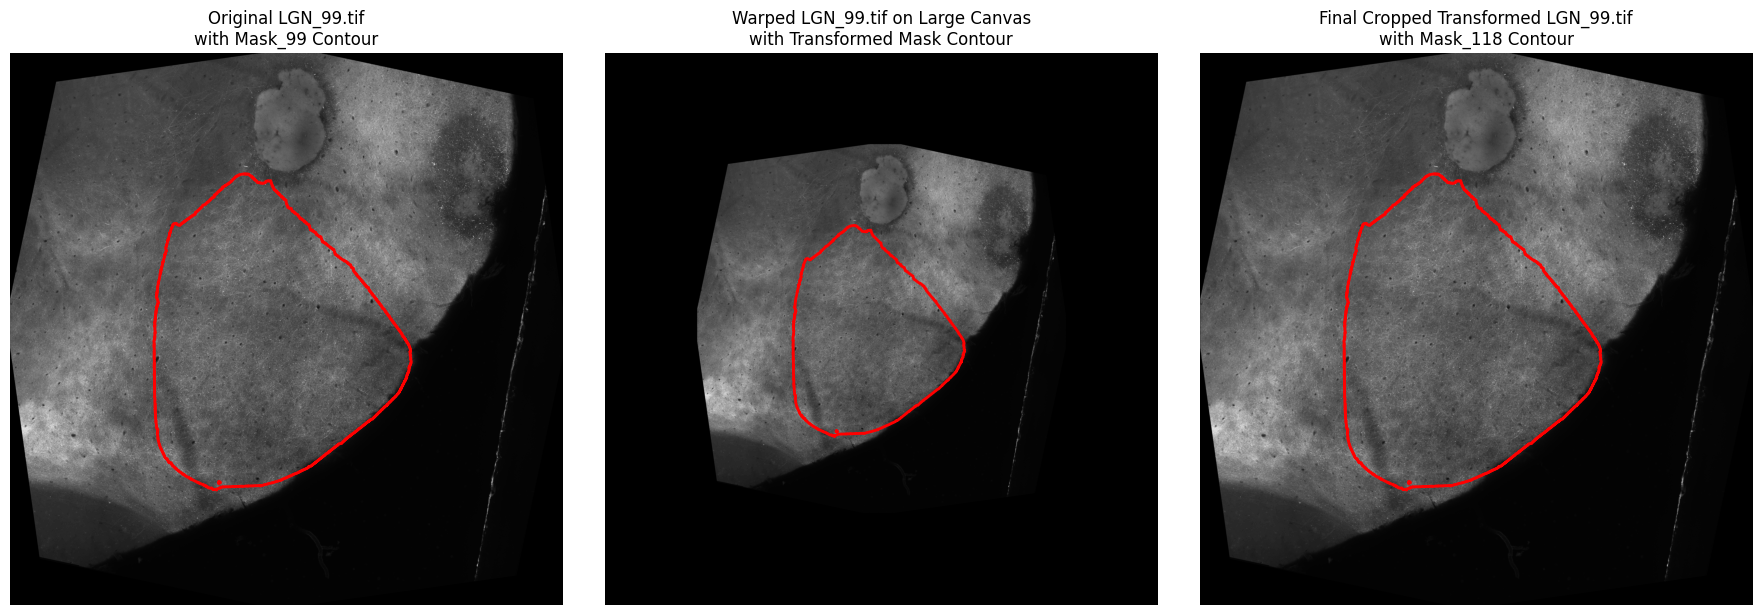

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, transform, img_as_float
from skimage.measure import find_contours

def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the source ellipse to the target ellipse.
    Steps:
      1) Translate source centroid to origin.
      2) Rotate by -orient_s to align the major axis with the x-axis.
      3) Scale x and y by (major_t/major_s) and (minor_t/minor_s), respectively.
      4) Rotate by orient_t.
      5) Translate to target centroid.
    """
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    R1 = transform.AffineTransform(rotation=-orient_s)
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    R2 = transform.AffineTransform(rotation=orient_t)
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))
    return T2 + R2 + S + R1 + T1

# ---------------------------
# 1. Load the Images and Masks
# ---------------------------
# LGN image to transform
LGN_img = img_as_float(io.imread('LGN_118.tif'))
# Source mask (used for computing the transform)
mask_src = img_as_float(io.imread('Mask_118.tif')) > 0.5
# Target mask (defines desired alignment)
mask_dst = img_as_float(io.imread('Mask_118.tif')) > 0.5

# ---------------------------
# 2. Set Up a Larger Canvas
# ---------------------------
# Use the destination mask dimensions and create a larger canvas (1.5× bigger)
H, W = mask_dst.shape
newH, newW = int(1.5 * H), int(1.5 * W)
offset_y, offset_x = (newH - H) / 2.0, (newW - W) / 2.0
offset_y_int, offset_x_int = int(offset_y), int(offset_x)

# ---------------------------
# 3. Compute Ellipse Parameters from the Masks
# ---------------------------
props_src = measure.regionprops(mask_src.astype(int))
props_dst = measure.regionprops(mask_dst.astype(int))
region_src = props_src[0]  # assume largest region
region_dst = props_dst[0]

# Centroids are returned as (row, col)
cy_s, cx_s = region_src.centroid
cy_t, cx_t = region_dst.centroid

# Adjust destination centroid for the larger canvas
cy_t_large = cy_t + offset_y
cx_t_large = cx_t + offset_x

# regionprops.orientation is from the vertical axis.
# Convert to an angle measured from the horizontal axis.
orient_s = np.pi/2 - region_src.orientation
orient_t = np.pi/2 - region_dst.orientation

major_s = region_src.major_axis_length
minor_s = region_src.minor_axis_length
major_t = region_dst.major_axis_length
minor_t = region_dst.minor_axis_length

print("Source mask ellipse parameters:")
print(f"  Centroid (row, col): ({cy_s:.2f}, {cx_s:.2f})")
print(f"  Orientation (horizontal-based): {orient_s:.2f} rad")
print(f"  Major axis: {major_s:.2f}, Minor axis: {minor_s:.2f}")

print("\nDestination mask ellipse parameters:")
print(f"  Centroid (row, col): ({cy_t:.2f}, {cx_t:.2f})")
print(f"  Adjusted Centroid (large canvas): ({cy_t_large:.2f}, {cx_t_large:.2f})")
print(f"  Orientation (horizontal-based): {orient_t:.2f} rad")
print(f"  Major axis: {major_t:.2f}, Minor axis: {minor_t:.2f}")

# ---------------------------
# 4. Compute the Affine Transformation
# ---------------------------
affine_tform = ellipse_to_ellipse_transform(
    cx_s, cy_s, orient_s, major_s, minor_s,
    cx_t_large, cy_t_large, orient_t, major_t, minor_t
)

# ---------------------------
# 5. Determine Extra Translation via the Source Mask
# ---------------------------
# Warp the source mask with the computed transform
warped_mask = transform.warp(mask_src.astype(float),
                             inverse_map=affine_tform.inverse,
                             output_shape=(newH, newW))
warped_mask_bin = warped_mask > 0.5

# Compute region properties of the warped mask to find its centroid
props_warped = measure.regionprops(warped_mask_bin.astype(int))
region_warped = props_warped[0]
cy_w, cx_w = region_warped.centroid

# Calculate additional pure translation needed for precise alignment
delta_x = cx_t_large - cx_w
delta_y = cy_t_large - cy_w
print(f"\nExtra pure shift required: Δx = {delta_x:.2f}, Δy = {delta_y:.2f}")

T_adjust = transform.AffineTransform(translation=(delta_x, delta_y))

# ---------------------------
# 6. Apply the Transformation to LGN_99.tif
# ---------------------------
# First, apply the affine transformation on the large canvas.
warped_LGN = transform.warp(LGN_img, inverse_map=affine_tform.inverse, output_shape=(newH, newW))
# Then, apply the additional pure translation.
warped_LGN_adjusted = transform.warp(warped_LGN, inverse_map=T_adjust.inverse, output_shape=(newH, newW))
# Finally, crop back to the original destination mask size.
final_LGN = warped_LGN_adjusted[offset_y_int:offset_y_int+H, offset_x_int:offset_x_int+W]

# ---------------------------
# 7. Compute Mask Contours and Visualize Each Image
# ---------------------------
# Compute contours using find_contours (level=0.5)
contours_src = find_contours(mask_src, level=0.5)
contours_warped = find_contours(warped_mask_bin, level=0.5)
contours_dst = find_contours(mask_dst, level=0.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Original LGN_99.tif with the source mask contour (Mask_99.tif)
axes[0].imshow(LGN_img, cmap='gray')
for contour in contours_src:
    axes[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axes[0].set_title("Original LGN_99.tif\nwith Mask_99 Contour")
axes[0].axis('off')

# Panel 2: Warped LGN image on the large canvas with the transformed mask contour
axes[1].imshow(warped_LGN_adjusted, cmap='gray')
for contour in contours_warped:
    axes[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axes[1].set_title("Warped LGN_99.tif on Large Canvas\nwith Transformed Mask Contour")
axes[1].axis('off')

# Panel 3: Final cropped transformed LGN image with the destination mask contour (Mask_118.tif)
axes[2].imshow(final_LGN, cmap='gray')
for contour in contours_dst:
    axes[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axes[2].set_title("Final Cropped Transformed LGN_99.tif\nwith Mask_118 Contour")
axes[2].axis('off')

plt.tight_layout()
plt.show()


Pixel size: 0.640221 micron/pixel
Found 12481 candidate ROIs within the transformed mask.
          x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0      1180   710       7.298432        4.672610           -0.023063   
1      1190   710       7.296642        4.671464           -0.018734   
2      1200   710       7.381286        4.725655           -0.013729   
3      1210   710       7.401690        4.738718           -0.013847   
4      1220   710       7.499517        4.801348           -0.014769   
...     ...   ...            ...             ...                 ...   
12476  1170  2190       6.298767        4.032603           -0.032360   
12477  1180  2190       6.247184        3.999578           -0.028787   
12478  1190  2190       6.225501        3.985697           -0.023540   
12479  1200  2190       6.210947        3.976379           -0.023395   
12480  1210  2190       6.264891        4.010915           -0.025450   

       second_positive_distance_pixels  secon

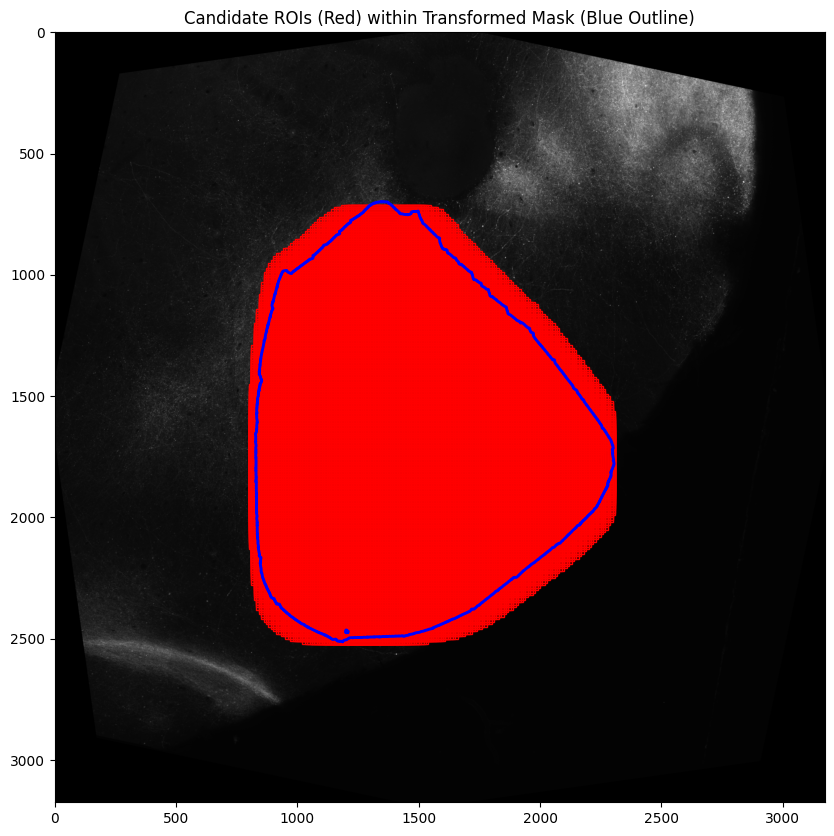

metrics_df was saved as metrics_df/LGN_99_transformed.csv


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float, measure, transform
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter, map_coordinates
from numpy.fft import fft2, ifft2, fftshift
import pandas as pd
from pathlib import Path
import multiprocessing as mp
import cupy as cp
import cupyx.scipy.ndimage as cndimage

#########################################
# Functions for Autocorrelation Analysis
#########################################
def next_power_of_two(n):
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    return g_small - g_large

def pad_image_with_mean(image, pad_size):
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    return fftshift(auto_corr)

def radial_profile(data, center, max_radius):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    radial_mean = []
    radii = np.arange(0, max_radius+1)
    for r_val in radii:
        mask = (r >= r_val) & (r < r_val+1)
        if np.any(mask):
            radial_mean.append(data[mask].mean())
        else:
            radial_mean.append(np.nan)
    return radii, np.array(radial_mean)

def background_subtract_gpu(image, selem_radius=50):
    image_gpu = cp.asarray(image)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, radial_limit_factor=0.3, debug=False,
                                   subtract_background=False, rolling_radius=50):
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    if debug:
        print("Padded size:", new_size)
    padded_image, _, _ = pad_image_with_mean(image_filtered, new_size)
    if debug:
        plt.figure(); plt.imshow(padded_image, cmap='gray'); plt.title("Padded Image"); plt.colorbar(); plt.show()
    
    auto_corr = compute_autocorrelation(padded_image)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("Autocorrelation (Raw)"); plt.colorbar(); plt.show()
    
    auto_corr -= n_pixels * (image_mean**2)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("After Mean Subtraction"); plt.colorbar(); plt.show()
    
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0
    auto_corr_corrected = auto_corr / ref_corr
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis'); plt.title("Corrected Autocorrelation"); plt.colorbar(); plt.show()
    
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if debug:
        print("Normalization value (center):", norm_value)
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    
    max_radius = new_size // 2
    radii, profile = radial_profile(auto_corr_corrected, (center, center), max_radius)
    if debug:
        plt.figure(); plt.plot(radii, profile, marker='o'); 
        plt.title("Radial Profile"); plt.xlabel("Radius (pixels)"); plt.ylabel("Normalized Autocorrelation");
        plt.grid(True); plt.show()
    
    return radii, profile, auto_corr_corrected

##############################################
# Transformation Function
##############################################
def ellipse_to_ellipse_transform(cx_s, cy_s, orient_s, major_s, minor_s,
                                 cx_t, cy_t, orient_t, major_t, minor_t):
    """
    Build an AffineTransform that maps the source ellipse to the target ellipse.
    Steps:
      1) Translate source centroid to origin.
      2) Rotate by -orient_s to align the major axis with the x-axis.
      3) Scale x and y by (major_t/major_s) and (minor_t/minor_s), respectively.
      4) Rotate by orient_t.
      5) Translate to target centroid.
    """
    T1 = transform.AffineTransform(translation=(-cx_s, -cy_s))
    R1 = transform.AffineTransform(rotation=-orient_s)
    sx = major_t / major_s
    sy = minor_t / minor_s
    S = transform.AffineTransform(scale=(sx, sy))
    R2 = transform.AffineTransform(rotation=orient_t)
    T2 = transform.AffineTransform(translation=(cx_t, cy_t))
    return T2 + R2 + S + R1 + T1

##############################################
# Global variables for multiprocessing workers
##############################################
global_rsc_img = None
global_pixel_size = None
roi_size = 330  # ROI dimensions in pixels

def process_tile(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    # Compute autocorrelation radial profile and corrected autocorrelation map
    radii, profile, auto_corr_map = autocorrelation_radial_profile(
        roi, do_bandpass=True, sigma_small=3, sigma_large=40,
        pad_factor=1.3, radial_limit_factor=0.3, debug=False,
        subtract_background=True, rolling_radius=50)
    
    # Metric 1: 50% width of the first peak
    r_half = None
    for i in range(1, len(profile)):
        if profile[i] <= 0.5:
            r_half = radii[i-1] + (0.5 - profile[i-1])*(radii[i]-radii[i-1])/(profile[i]-profile[i-1])
            break
    
    # Metric 2: Amplitude of the first negative peak
    first_negative_amp = None
    for i in range(1, len(profile)-1):
        if profile[i] < 0 and profile[i] < profile[i-1] and profile[i] < profile[i+1]:
            first_negative_amp = profile[i]
            break
    
    # Metric 3: Distance to the second positive peak
    second_positive_distance = None
    for i in range(1, len(profile)-1):
        if profile[i] > 0 and profile[i] > profile[i-1] and profile[i] > profile[i+1]:
            second_positive_distance = radii[i]
            break

    # Metric 4: Orientation of maximum on the circle.
    new_size_map = auto_corr_map.shape[0]  # assume square
    center_pt = np.array([new_size_map//2, new_size_map//2])
    Y, X = np.indices(auto_corr_map.shape)
    r_map = np.sqrt((X - center_pt[1])**2 + (Y - center_pt[0])**2)
    exclusion_mask = r_map > 5  # exclude center
    neg_vals = auto_corr_map[exclusion_mask]
    min_val = np.min(neg_vals)
    min_coords = np.argwhere((auto_corr_map == min_val) & exclusion_mask)
    if min_coords.shape[0] > 0:
        min_coord = min_coords[0]
    else:
        min_coord = center_pt
    vec = np.array([min_coord[1] - center_pt[1], min_coord[0] - center_pt[0]])
    R_val = np.linalg.norm(vec)
    num_samples = 360
    angles = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
    circle_vals = []
    for angle in angles:
        x_sample = center_pt[1] + R_val * np.cos(angle)
        y_sample = center_pt[0] + R_val * np.sin(angle)
        val = map_coordinates(auto_corr_map, [[y_sample], [x_sample]], order=1, mode='reflect')[0]
        circle_vals.append(val)
    circle_vals = np.array(circle_vals)
    max_index = np.argmax(circle_vals)
    orientation_max = angles[max_index]  # in radians

    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None,
        'orientation_max_radians': orientation_max,
        'orientation_max_degrees': np.degrees(orientation_max)
    }

##############################################
# Main Code: Registration, Tiling & Metrics Extraction
##############################################
if __name__ == "__main__":
    # --- Part 1: Registration Transformation ---
    # File paths for original images/masks
    # --- Define file paths ---
    # For example, using the LGN_99 dataset.
    base_name = "ACC_118"
    csv_file_path = Path("metrics_df") / f"{base_name}_transformed.csv"
    tif_file_path = Path(f"{base_name}.tif")
    mask_src_path = Path(f"Mask_{base_name.split('_')[-1]}.tif")  # e.g. 'Mask_99.tif'
    #lgn_path = 'LGN_82.tif'
    #mask_src_path = 'Mask_82.tif'
    mask_dst_path = 'Mask_118.tif'
    
    # Load images and masks
    LGN_img = tifffile.imread(tif_file_path)
    mask_src = tifffile.imread(mask_src_path)
    mask_dst = tifffile.imread(mask_dst_path)
    
    LGN_img = img_as_float(LGN_img)
    mask_src = img_as_float(mask_src) > 0.5
    mask_dst = img_as_float(mask_dst) > 0.5
    
    # Extract pixel size from LGN metadata
    with tifffile.TiffFile(tif_file_path) as tif:
        page = tif.pages[0]
        x_res_fraction = page.tags['XResolution'].value
        pixel_size = x_res_fraction[0] / x_res_fraction[1]
        print("Pixel size:", pixel_size, "micron/pixel")
    
    # Set up a larger canvas based on destination mask dimensions
    H, W = mask_dst.shape
    newH, newW = int(1.5 * H), int(1.5 * W)
    offset_y, offset_x = (newH - H) / 2.0, (newW - W) / 2.0
    offset_y_int, offset_x_int = int(offset_y), int(offset_x)
    
    # Compute ellipse parameters from source and destination masks
    props_src = measure.regionprops(mask_src.astype(int))
    props_dst = measure.regionprops(mask_dst.astype(int))
    region_src = props_src[0]
    region_dst = props_dst[0]
    
    cy_s, cx_s = region_src.centroid
    cy_t, cx_t = region_dst.centroid
    # Adjust destination centroid to the larger canvas
    cy_t_large = cy_t + offset_y
    cx_t_large = cx_t + offset_x
    
    orient_s = np.pi/2 - region_src.orientation
    orient_t = np.pi/2 - region_dst.orientation
    major_s = region_src.major_axis_length
    minor_s = region_src.minor_axis_length
    major_t = region_dst.major_axis_length
    minor_t = region_dst.minor_axis_length
    
    # Compute the affine transform mapping source mask to destination mask
    affine_tform = ellipse_to_ellipse_transform(
        cx_s, cy_s, orient_s, major_s, minor_s,
        cx_t_large, cy_t_large, orient_t, major_t, minor_t
    )
    
    # Warp the source mask on the large canvas
    warped_mask = transform.warp(mask_src.astype(float),
                                 inverse_map=affine_tform.inverse,
                                 output_shape=(newH, newW))
    warped_mask_bin = warped_mask > 0.5
    # Compute extra translation for precise alignment
    props_warped = measure.regionprops(warped_mask_bin.astype(int))
    region_warped = props_warped[0]
    cy_w, cx_w = region_warped.centroid
    delta_x = cx_t_large - cx_w
    delta_y = cy_t_large - cy_w
    T_adjust = transform.AffineTransform(translation=(delta_x, delta_y))
    
    warped_mask_adjusted = transform.warp(warped_mask_bin.astype(float),
                                          inverse_map=T_adjust.inverse,
                                          output_shape=(newH, newW))
    warped_mask_adjusted_bin = warped_mask_adjusted > 0.5
    # Crop final transformed mask to destination dimensions
    final_mask = warped_mask_adjusted_bin[offset_y_int:offset_y_int+H, offset_x_int:offset_x_int+W]
    
    # Similarly, transform the LGN image
    warped_LGN = transform.warp(LGN_img, inverse_map=affine_tform.inverse, output_shape=(newH, newW))
    warped_LGN_adjusted = transform.warp(warped_LGN, inverse_map=T_adjust.inverse, output_shape=(newH, newW))
    final_LGN = warped_LGN_adjusted[offset_y_int:offset_y_int+H, offset_x_int:offset_x_int+W]
    
    # --- Part 2: Tiling and Parallel Metrics Extraction on the Transformed Image ---
    # Use the transformed LGN image (final_LGN) and transformed mask (final_mask) for ROI selection.
    global_rsc_img = final_LGN
    global_pixel_size = pixel_size
    
    # Tiling parameters: use the transformed mask to choose candidate ROIs.
    stride = 10  # slide window by 10 pixels
    coverage_threshold = 0.9  # require at least 90% mask coverage in ROI
    tile_positions = []
    for y in range(0, final_LGN.shape[0] - roi_size + 1, stride):
        for x in range(0, final_LGN.shape[1] - roi_size + 1, stride):
            roi_mask = final_mask[y:y+roi_size, x:x+roi_size]
            if roi_mask.mean() >= coverage_threshold:
                tile_positions.append((x, y))
    
    print(f"Found {len(tile_positions)} candidate ROIs within the transformed mask.")
    
    # Process candidate ROIs in parallel.
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_tile, tile_positions)
    
    metrics_df = pd.DataFrame(results)
    print(metrics_df)
    
    # --- Visualization ---
    # Draw candidate ROI rectangles and overlay the transformed mask outline.
    import matplotlib.patches as patches
    fig, ax = plt.subplots(figsize=(10,10))
    # Use the transformed LGN image for visualization.
    ax.imshow(final_LGN, cmap='gray')
    for (x, y) in tile_positions:
        rect = patches.Rectangle((x, y), roi_size, roi_size, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    # Overlay the transformed mask contour.
    contours = find_contours(final_mask, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
    ax.set_title("Candidate ROIs (Red) within Transformed Mask (Blue Outline)")
    plt.show()
    
    # Save the metrics dataframe.
    metrics_dir = Path("./metrics_df")
    metrics_dir.mkdir(exist_ok=True)
    #csv_filename = "LGN_99_transformed.csv"
    #csv_path = metrics_dir / csv_filename
    metrics_df.to_csv(csv_file_path, index=False)
    print(f"metrics_df was saved as {csv_path}")
